In [1]:
%load_ext autoreload
%autoreload 2

# Import and Setup

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gc
import json
import pprint
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import partial
from argparse import Namespace
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *


import wandb
from wandb.keras import WandbCallback

from model import SimpleSupervisedtModel, ArcFaceSupervisedModel, get_feature_extractor
from config import get_train_config
from data import GetDataloader
from utils import ShowBatch, id_generator, get_stratified_k_fold
from callbacks import GetCallbacks

pp = pprint.PrettyPrinter(indent=1)

In [3]:
args = get_train_config()

random_id = id_generator(size=8)
args.exp_id = random_id

In [4]:
DEBUG = True

# Prepare Dataset

In [11]:
df = pd.read_csv('../cleaned_train_5_fold_individual_ids.csv')

with open('../label2ids_individual_ids.json') as json_file:
    label2ids = json.load(json_file)
    
args.num_labels = len(label2ids)
args.labels = label2ids

df.head()

,image,species,individual_id,img_path,fold,target
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,../128x128/train_images-128-128/train_images-1...,0,0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,../128x128/train_images-128-128/train_images-1...,2,1
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,../128x128/train_images-128-128/train_images-1...,4,2
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,../128x128/train_images-128-128/train_images-1...,4,3
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,../128x128/train_images-128-128/train_images-1...,1,4


# Dataloader

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


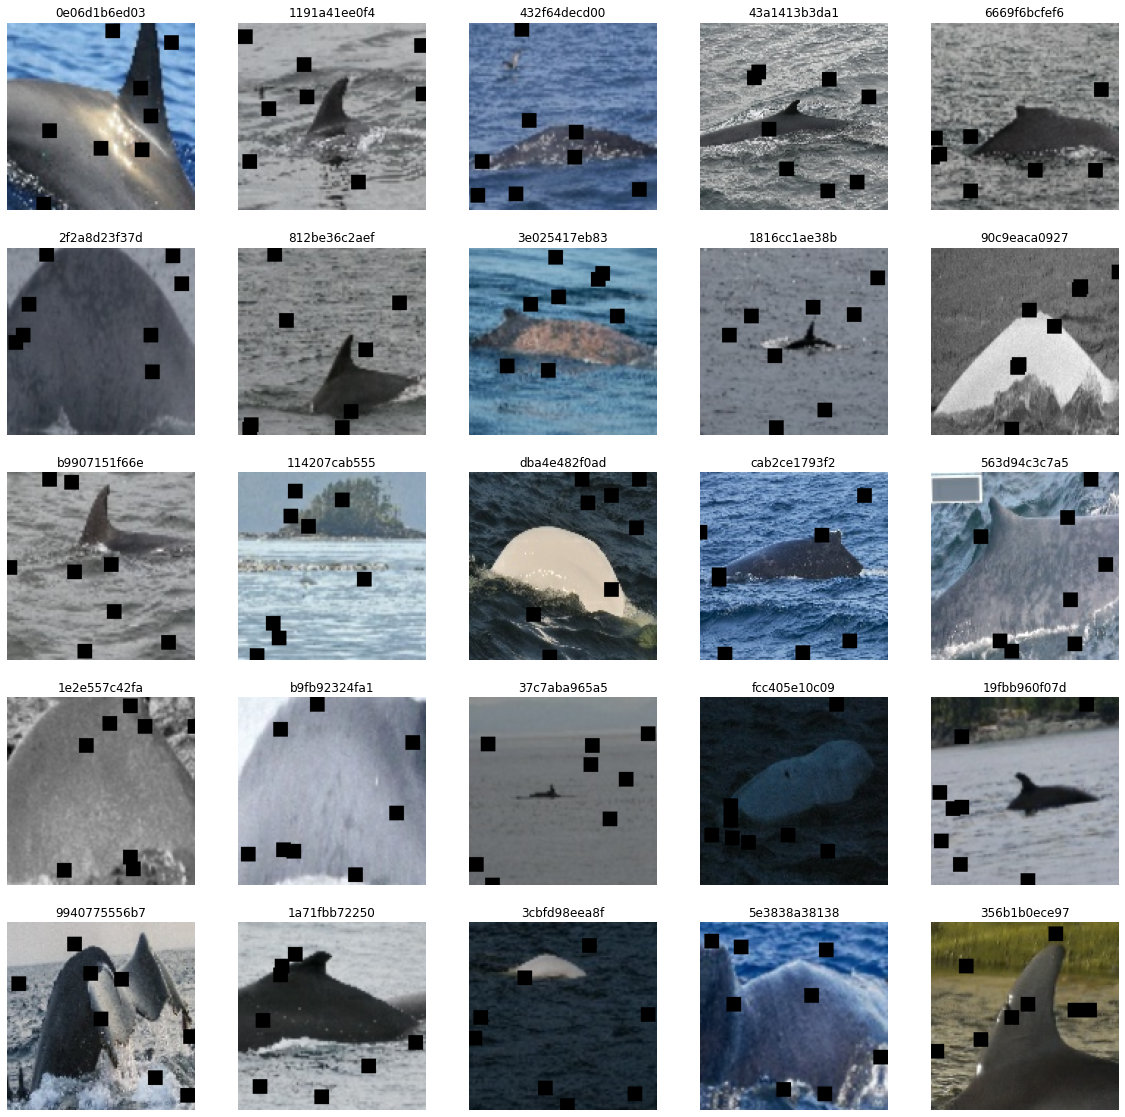

In [12]:
# Sanity check
if DEBUG:
    # Get Split
    train_df = df[df.fold != 0]
    valid_df = df[df.fold == 0]

    # Get train and validation loaders
    dataset = GetDataloader(args)
    trainloader = dataset.dataloader(train_df, data_type='train')
    validloader = dataset.dataloader(valid_df, data_type='valid')

    # Display a batch
    if args.use_arcface:
        sample_inputs, sample_labels = next(iter(trainloader))
        sample_imgs, sample_labels = sample_inputs['img_input'], sample_inputs['label_input']
    else:
        sample_imgs, sample_labels = next(iter(trainloader))

    show_batch = ShowBatch(args)
    show_batch.show_batch(sample_imgs, sample_labels)

# Model

In [13]:
if DEBUG:
    tf.keras.backend.clear_session()
    
    if args.use_arcface:
        get_model = ArcFaceSupervisedModel(args)
    else:
        get_model = SimpleSupervisedtModel(args)
        
    model = get_model.get_efficientnet()
    model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 15587)             19966947  
Total params: 24,016,518
Trainable params: 23,974,495
Non-trainable params: 42,023
_________________________________________________________________


# Callbacks

In [14]:
callbacks = GetCallbacks(args)

# Train

In [15]:
if DEBUG:
    args.epochs = 10
    args.num_folds = 1

for fold in range(args.num_folds):
    # Get dataloaders
    train_df = df[df.fold != fold]
    valid_df = df[df.fold == fold]

    dataset = GetDataloader(args)
    trainloader = dataset.dataloader(train_df)
    validloader = dataset.dataloader(valid_df, data_type='valid')
    
    # Initialize model
    tf.keras.backend.clear_session()
    if args.use_arcface:
        get_model = ArcFaceSupervisedModel(args)
    else:
        get_model = SimpleSupervisedtModel(args)
        
    model = get_model.get_efficientnet()

    # Compile model
    optimizer = 'adam'
    if args.use_arcface:
        loss = 'binary_crossentropy'
    else:
        loss = 'categorical_crossentropy'
        
    model.compile(optimizer,
                  loss=loss,
                  metrics=['acc',
                           tf.keras.metrics.TopKCategoricalAccuracy(1, name='top@1_acc'),
                           tf.keras.metrics.TopKCategoricalAccuracy(5, name='top@5_acc')])

    # Initialize W&B run
    run = wandb.init(project='happywhale',
                     config=vars(args),
                     group=f'effnetb0-{args.exp_id}',
                     job_type='train',
                     name=f'{args.exp_id}_{fold}_train')

    # Train
    model.fit(trainloader,
              epochs=args.epochs,
              validation_data=validloader,
              callbacks=[WandbCallback(save_model=False),
                         callbacks.get_reduce_lr_on_plateau()])
    
    # Save the model
    os.makedirs(f'{args.model_save_path}/{args.exp_id}', exist_ok=True)
    model.save(f'{args.model_save_path}/{args.exp_id}/model_{fold}')
    
    # Load the model
    model = tf.keras.models.load_model(f'{args.model_save_path}/{args.exp_id}/model_{fold}')
    
    # Evaluate and prepare oof 
    preds = model.predict(validloader)
    df.loc[list(df[df.fold == fold].index), 'preds'] = np.argmax(preds, axis=1)
    
    # Get Embedding and save it as npz files along with validation index
    feature_extractor = get_feature_extractor(model)
    embedding = feature_extractor.predict(validloader)

    os.makedirs(f'{args.embedding_save_path}/{args.exp_id}', exist_ok=True)
    np.savez(f'{args.embedding_save_path}/{args.exp_id}/embedding_{fold}.npz',
             embedding=embedding,
             index=np.array(valid_df.index))
    
    del trainloader, validloader, model, feature_extractor, embedding
    _ = gc.collect()

    # Close W&B run
    run.finish()
    
df[['image', 'individual_id', 'target', 'preds']].to_csv('../oof.csv', index=False)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: WARNING Serializing object of type dict that is 589936 bytes


Epoch 1/10
160/160 [==============================] - 113s 467ms/step - loss: 8.3648 - acc: 0.0147 - top@1_acc: 0.0147 - top@5_acc: 0.0459 - val_loss: 7.5627 - val_acc: 0.0258 - val_top@1_acc: 0.0258 - val_top@5_acc: 0.0838
Epoch 2/10
160/160 [==============================] - 61s 382ms/step - loss: 7.2216 - acc: 0.0336 - top@1_acc: 0.0336 - top@5_acc: 0.0997 - val_loss: 7.0915 - val_acc: 0.0403 - val_top@1_acc: 0.0403 - val_top@5_acc: 0.1213
Epoch 3/10
160/160 [==============================] - 62s 383ms/step - loss: 6.4970 - acc: 0.0580 - top@1_acc: 0.0580 - top@5_acc: 0.1524 - val_loss: 6.9074 - val_acc: 0.0573 - val_top@1_acc: 0.0573 - val_top@5_acc: 0.1484
Epoch 4/10
160/160 [==============================] - 61s 380ms/step - loss: 5.7578 - acc: 0.0878 - top@1_acc: 0.0878 - top@5_acc: 0.2167 - val_loss: 6.9450 - val_acc: 0.0715 - val_top@1_acc: 0.0715 - val_top@5_acc: 0.1676
Epoch 5/10
160/160 [==============================] - 61s 380ms/step - loss: 5.0172 - acc: 0.1278 - top@1_a

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


acc,▁▁▂▂▃▄▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▂▁▁▁
top@1_acc,▁▁▂▂▃▄▆▇▇█
top@5_acc,▁▂▂▃▄▅▇▇██
val_acc,▁▂▃▅▅▆▇▇██
val_loss,█▃▁▁▂▄▃▃▃▂
val_top@1_acc,▁▂▃▅▅▆▇▇██
val_top@5_acc,▁▃▄▅▅▆▇▇██
acc,0.3887
best_epoch,2


In [20]:
oof_df = pd.read_csv('../oof.csv')
oof_df_copy = oof_df.copy()

def correct_preds(row):
    return int(row.preds)

oof_df_copy['preds'] = oof_df_copy.apply(lambda row: correct_preds(row), axis=1)

metric = tf.keras.metrics.SparseCategoricalCrossentropy()
metric.update_state(oof_df_copy.target.values.reshape(-1,1), oof_df_copy.preds.values.reshape(-1,1))
print(f'CV Score: {metric.result().numpy()}')

In [52]:
oof_df_copy[oof_df_copy.target == oof_df_copy.preds]

,image,species,individual_id,img_path,target,fold,preds
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,../128x128/train_images-128-128/train_images-1...,0,2.0,0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,../128x128/train_images-128-128/train_images-1...,1,3.0,1
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,../128x128/train_images-128-128/train_images-1...,2,2.0,2
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,../128x128/train_images-128-128/train_images-1...,3,2.0,3
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,../128x128/train_images-128-128/train_images-1...,1,4.0,1
...,...,...,...,...,...,...,...
51027,fff603f5af8614.jpg,fin_whale,40fe65946167,../128x128/train_images-128-128/train_images-1...,6,3.0,6
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1,../128x128/train_images-128-128/train_images-1...,4,4.0,4
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9,../128x128/train_images-128-128/train_images-1...,7,3.0,7
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e,../128x128/train_images-128-128/train_images-1...,4,0.0,4
